# Synchronization

In various cases the seismic data can be recorded by different instruments with different sampling rates and start times, or have a time-varying time delta. This notebook demonstrates how to synchronize a stream of with different traces using the `covseisnet.stream.NetworkStream.synchronize` method. This method finds the latest start time and the earliest end time among the traces in the stream, and interpolates the traces between these times with a common sampling interval. More information about the method can be found in the documentation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import covseisnet as csn

## Read the seismic waveforms

This section reads an [example stream of seismic data shipped with Obspy](https://examples.obspy.org). The stream contains three traces, which are highpass at a very high frequency to see more details in the synchronization.

In [2]:
# Read the example stream. Using the read method without arguments reads the
# example stream shipped with Obspy.
stream = csn.read()

# Highpass filter the stream to better see the synchronization.
stream.filter("highpass", freq=1)

# Cut the stream out of the tapering. The cut method is a wrapper around the
# trim method but allows to give dates as strings (thus avoiding importing
# Obspy UTCDateTime explicitely).
stream.cut("2009-08-24T00:20:20", duration=0.2)

# Print the original stream. The header of the NetworkStream object indicates
# that the traces are sampled on the same sampling times.
print(stream)

3 Trace(s) in NetworkStream (synced):
BW.RJOB..EHZ | 2009-08-24T00:20:20.000000Z - 2009-08-24T00:20:20.200000Z | 100.0 Hz, 21 samples
BW.RJOB..EHN | 2009-08-24T00:20:20.000000Z - 2009-08-24T00:20:20.200000Z | 100.0 Hz, 21 samples
BW.RJOB..EHE | 2009-08-24T00:20:20.000000Z - 2009-08-24T00:20:20.200000Z | 100.0 Hz, 21 samples


## Desynchronize waveforms

This first section desynchronizes the traces in the stream, in order to demonstrate the synchronization method from the example stream. The traces are shifted in time by different random amount of times, and a small number of samples are collected for visualization. Note the change in the `NetworkStream` header when printed.

In [3]:
# Add a random shift to the traces (seeded for reproducibility)
np.random.seed(42)
for trace in stream:

    # Random shift
    shift_seconds = np.random.uniform(-0.005, 0.005)

    # Add the shift to the starttime of the trace
    trace.stats.starttime += shift_seconds

# Print the desynchronized stream (the header of the NetworkStream object
# indicates that the traces are not synced anymore).
print(stream)

3 Trace(s) in NetworkStream (not synced):
BW.RJOB..EHZ | 2009-08-24T00:20:19.998745Z - 2009-08-24T00:20:20.198745Z | 100.0 Hz, 21 samples
BW.RJOB..EHN | 2009-08-24T00:20:20.004507Z - 2009-08-24T00:20:20.204507Z | 100.0 Hz, 21 samples
BW.RJOB..EHE | 2009-08-24T00:20:20.002320Z - 2009-08-24T00:20:20.202320Z | 100.0 Hz, 21 samples


## Synchronize

We now synchronize the traces in the stream using the `covseisnet.stream.NetworkStream.synchronize` method. The method finds the latest start time and the earliest end time among the traces in the stream, and aligns the traces to these times with interpolation. It is also possible to specify different arguments for synchronization, such as the sampling rate, the interpolation method, the expected start and end times, etc.

In [4]:
# Synchronize the traces
processed_stream = stream.copy()
processed_stream.synchronize(interpolation_method="cubic")

# Print the synchronized stream, the header of the NetworkStream object
# indicates that the traces are now synchronized.
print(processed_stream)

3 Trace(s) in NetworkStream (synced):
BW.RJOB..EHZ | 2009-08-24T00:20:20.004507Z - 2009-08-24T00:20:20.194507Z | 100.0 Hz, 20 samples
BW.RJOB..EHN | 2009-08-24T00:20:20.004507Z - 2009-08-24T00:20:20.194507Z | 100.0 Hz, 20 samples
BW.RJOB..EHE | 2009-08-24T00:20:20.004507Z - 2009-08-24T00:20:20.194507Z | 100.0 Hz, 20 samples


## Compare traces

The synchronized traces are plotted alongside the original traces to compare
the effect of the synchronization method. Note that several interpolation
methods are available in the synchronization method. Check the documentation
for more information.



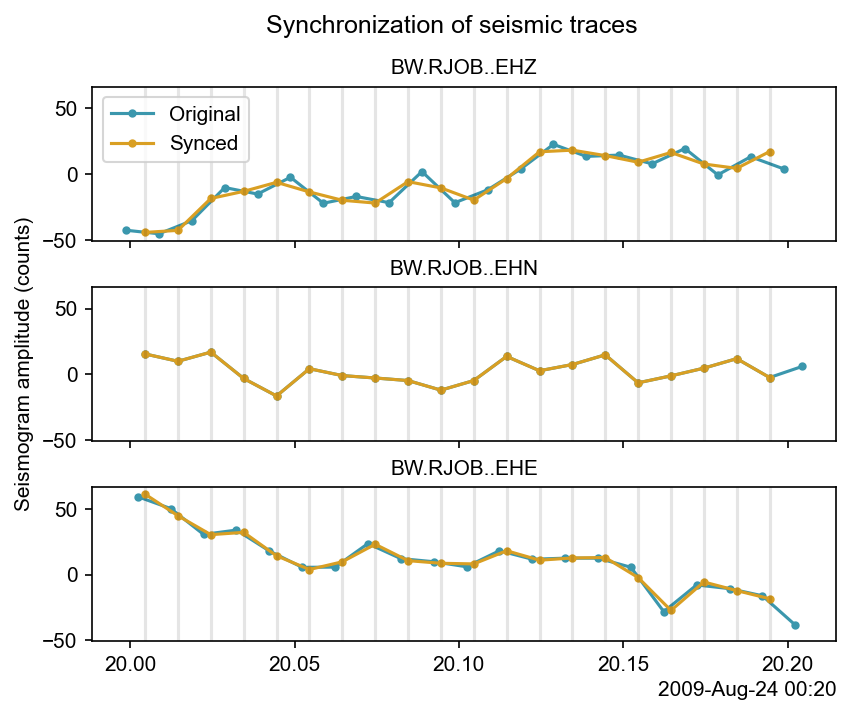

In [5]:
# Create figure
fig, axes = plt.subplots(3, sharex=True, sharey=True, gridspec_kw={"hspace": 0.3})

# Loop over traces
for trace, synced, ax in zip(stream, processed_stream, axes):

    # Plot traces
    ax.plot(trace.times("matplotlib"), trace.data, ".-", label="Original")
    ax.plot(synced.times("matplotlib"), synced.data, ".-", label="Synced")

    # Local settings
    ax.set_title(trace.id, size="medium")
    for time in synced.times("matplotlib"):
        ax.axvline(time, color="k", alpha=0.1)

# Labels
axes[0].legend(loc="upper left")
axes[1].set_ylabel("Seismogram amplitude (counts)")

# Figure title
fig.suptitle("Synchronization of seismic traces")

# Date formatting
csn.plot.dateticks(axes[-1])
plt.show()